In [1]:
import numpy as np
import pylab
from matplotlib import pyplot as plt

In [89]:
def load_data(X_filename='mnist_X.csv', label_filename='mnist_label.csv'):
    print('load data.....')
    # Implement load data related codes here
    X = np.genfromtxt(X_filename, delimiter=',') #5000*784
    Y = np.genfromtxt(label_filename, delimiter=',') #5000
    return X, Y

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X, Y=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """
    print("Preprocessing the data using PCA...")
    # Implement PCA here
    n, d = X.shape
    Y = Y.astype(np.int32)
    X = X - np.mean(X, axis=0)
    S = X.T.dot(X) / n
    eiga, eigv = np.linalg.eig(S)
    output = (X.dot(eigv[:, :no_dims]))
        
    return output.real, eigv[:, :no_dims].real

def lda(X, Y=np.array([])):
    """
        Runs LDA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """
    print("Preprocessing the data using LDA...")
    # Implement LDA here
    n, d = X.shape
    Y = Y.astype(np.int32)
    label = np.unique(Y)
    C = np.zeros((n, label.shape[0]))
    for l in label:
        C[Y == l, l-1] = 1
        
    Cj = np.sum(C, axis = 0)
    Mj = X.T.dot(C) / Cj
    M = np.sum(X.T, axis = 1) / n
    w = X.T - Mj.dot(C.T)
    
    SW = np.zeros((d, d))
    for l in label:
        SW += w[:, Y == l].dot(w[:, Y == l].T) / 1000
    SB = ((Mj.T - M).T * Cj).dot((Mj.T - M))
    
    SW_inv = np.linalg.pinv(SW)
    S = SW_inv.dot(SB)
     
    eiga, eigv = np.linalg.eig(np.cov(S))
    output = X.dot(eigv[:, :2])
        
    return output.real

def show(data, label):
    label = label.astype(np.int32)
    plt.figure(figsize=(8, 8))
    color=['r', 'g', 'b', 'c', 'y']
    for idx, d in enumerate(data):
        plt.scatter(d[0], d[1], c = color[label[idx]-1])
    plt.show()

def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, symmetric = False):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X, _ = pca(X, no_dims=initial_dims)
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))
    
    #1
    if symmetric:
        # use same random initial values
        Y_ssne = Y.copy()
        dY_ssne = dY.copy()
        iY_ssne = iY.copy()
        gains_ssne = gains.copy()
        Q_ssne = np.zeros((n, n))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.							# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        
        #2
        if symmetric:
            sum_Y_ssne = np.sum(np.square(Y_ssne), 1)
            num_ssne = -2. * np.dot(Y_ssne, Y_ssne.T)
            num_ssne = np.exp(-1 * np.add(np.add(num_ssne, sum_Y_ssne).T, sum_Y_ssne))
            num_ssne[range(n), range(n)] = 0.
            Q_ssne = num_ssne / np.sum(num_ssne)
            Q_ssne = np.maximum(Q_ssne, 1e-12)
        
        
        # Compute gradient
        PQ = P - Q
        #3
        if symmetric:
            PQ_ssne = P - Q_ssne
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0) 
            #4
            if symmetric:
                dY_ssne[i, :] = np.sum(np.tile(PQ_ssne[:, i], (no_dims, 1)).T * (Y_ssne[i, :] - Y_ssne), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
            
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))
        
        #5
        if symmetric:
            gains_ssne = (gains_ssne + 0.2) * ((dY_ssne > 0.) != (iY_ssne > 0.)) + \
                        (gains_ssne * 0.8) * ((dY_ssne > 0.) == (iY_ssne > 0.))
            gains_ssne[gains_ssne < min_gain] = min_gain
            iY_ssne = momentum * iY_ssne - eta * (gains_ssne * dY_ssne)
            Y_ssne = Y_ssne + iY_ssne
            Y_ssne = Y_ssne - np.tile(np.mean(Y_ssne, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            
            if symmetric:
                C_ssne = np.sum(P * np.log(P / Q_ssne))
                print("Iteration %d: tsne error is %f, ssne error is %f" % (iter + 1, C, C_ssne))
            else:
                print("Iteration %d: error is %f" % (iter + 1, C))
        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    if symmetric:
        return Y, Y_ssne, P, Q, Q_ssne
    else:
        return Y

In [90]:
X, Y = load_data()

load data.....


In [91]:
res_pca, _ = pca(X, Y, 2)
res_lda = lda(X, Y)
res_tsne, res_ssne, P, Q, Q_ssne = tsne(X, symmetric = True)

Preprocessing the data using PCA...
Preprocessing the data using LDA...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 5000...
Computing P-values for point 500 of 5000...
Computing P-values for point 1000 of 5000...
Computing P-values for point 1500 of 5000...
Computing P-values for point 2000 of 5000...
Computing P-values for point 2500 of 5000...
Computing P-values for point 3000 of 5000...
Computing P-values for point 3500 of 5000...
Computing P-values for point 4000 of 5000...
Computing P-values for point 4500 of 5000...
Mean value of sigma: 1.931174
Iteration 10: tsne error is 25.181401, ssne error is 25.250574
Iteration 20: tsne error is 24.224285, ssne error is 22.991346
Iteration 30: tsne error is 20.688276, ssne error is 18.273194
Iteration 40: tsne error is 18.930440, ssne error is 17.677507
Iteration 50: tsne error is 18.285038, ssne error is 17.583653
Iteration 60: tsne error is 18.021156, ssne error is 17.522185
Iterat

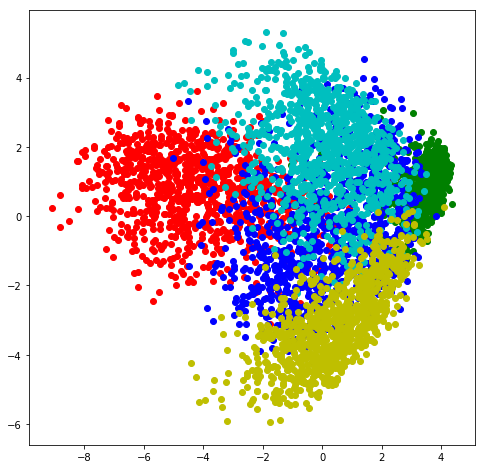

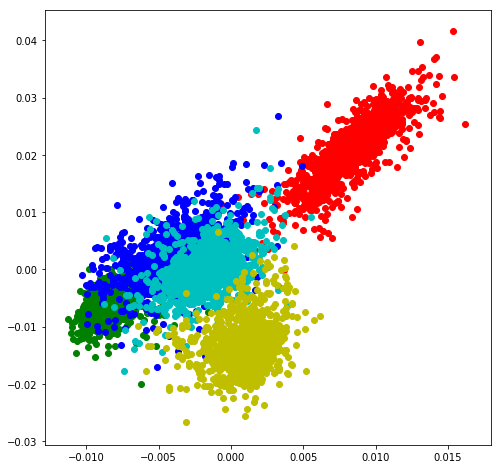

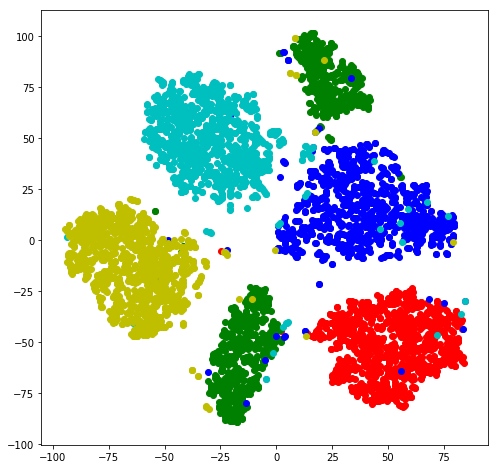

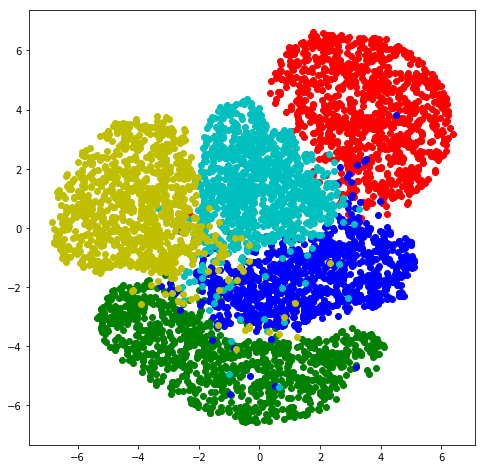

In [92]:
show(res_pca, Y)
show(res_lda, Y)
show(res_tsne, Y)
show(res_ssne, Y)

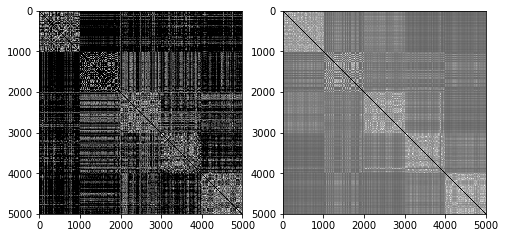

In [93]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(np.log(P), cmap='gray')
plt.subplot(122)
plt.imshow(np.log(Q), cmap='gray')
plt.show()

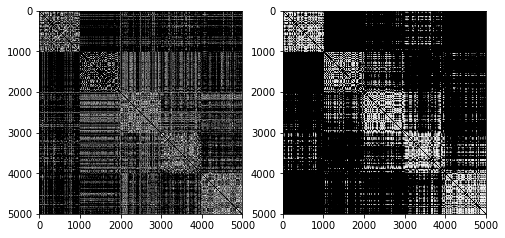

In [94]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(np.log(P), cmap='gray')
plt.subplot(122)
plt.imshow(np.log(Q_ssne), cmap='gray')
plt.show()

In [95]:
import cv2
import glob

In [96]:
att_faces = []
for name in glob.glob('./att_faces/*/*.pgm'):
    image = cv2.imread(name, -1)
    att_faces += [np.array(image).reshape(1, -1)]
att_faces = np.vstack(att_faces)

In [97]:
def showFaces(faces, col=10):
    f = faces.reshape(-1,112,92)
    n = f.shape[0]
    all_faces = []
    for i in range(n//col):
        all_faces += [np.hstack(f[col*i:col*(i+1)])]
    all_faces = np.vstack(all_faces)
    
    plt.figure(figsize=(4*(n//col),4*col))
    plt.imshow(all_faces, cmap='gray')
    plt.show()

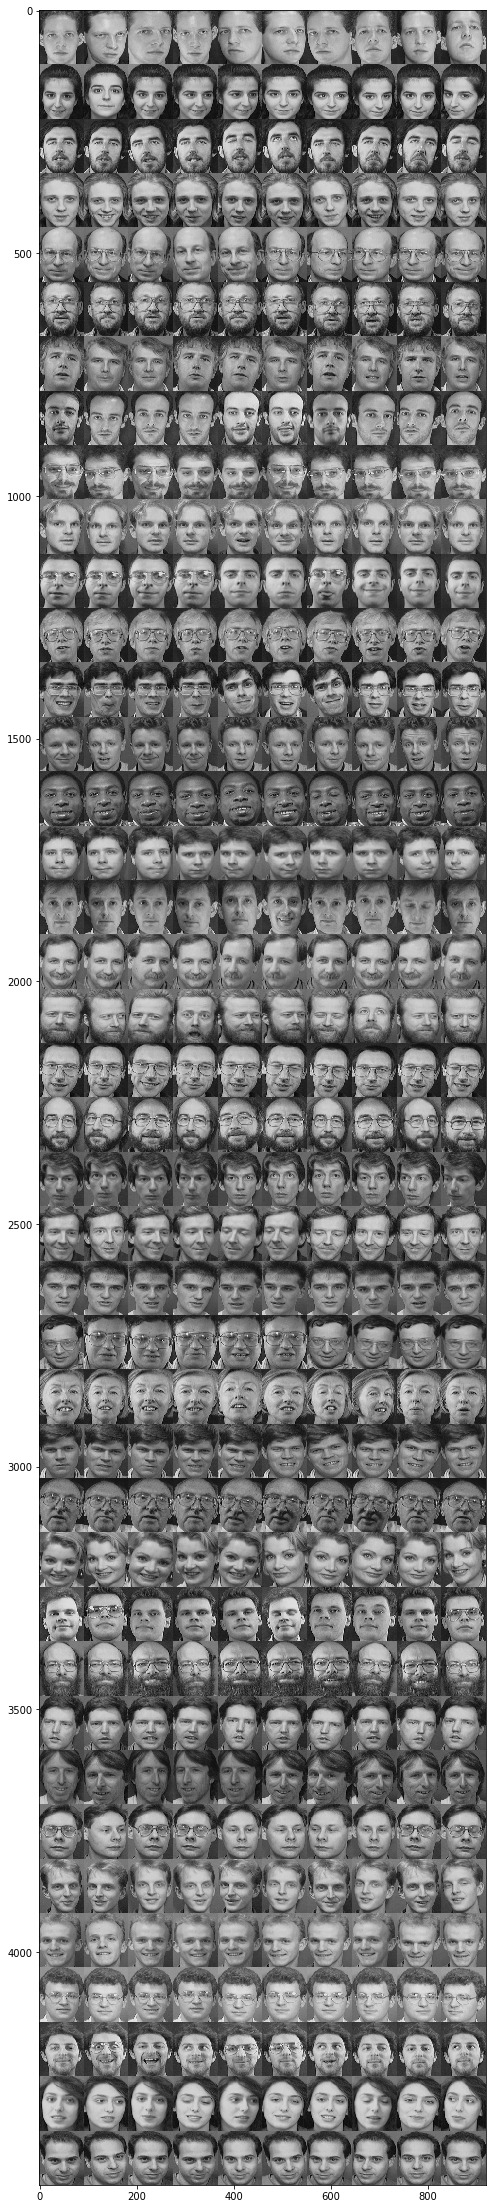

In [98]:
showFaces(att_faces)

Preprocessing the data using PCA...


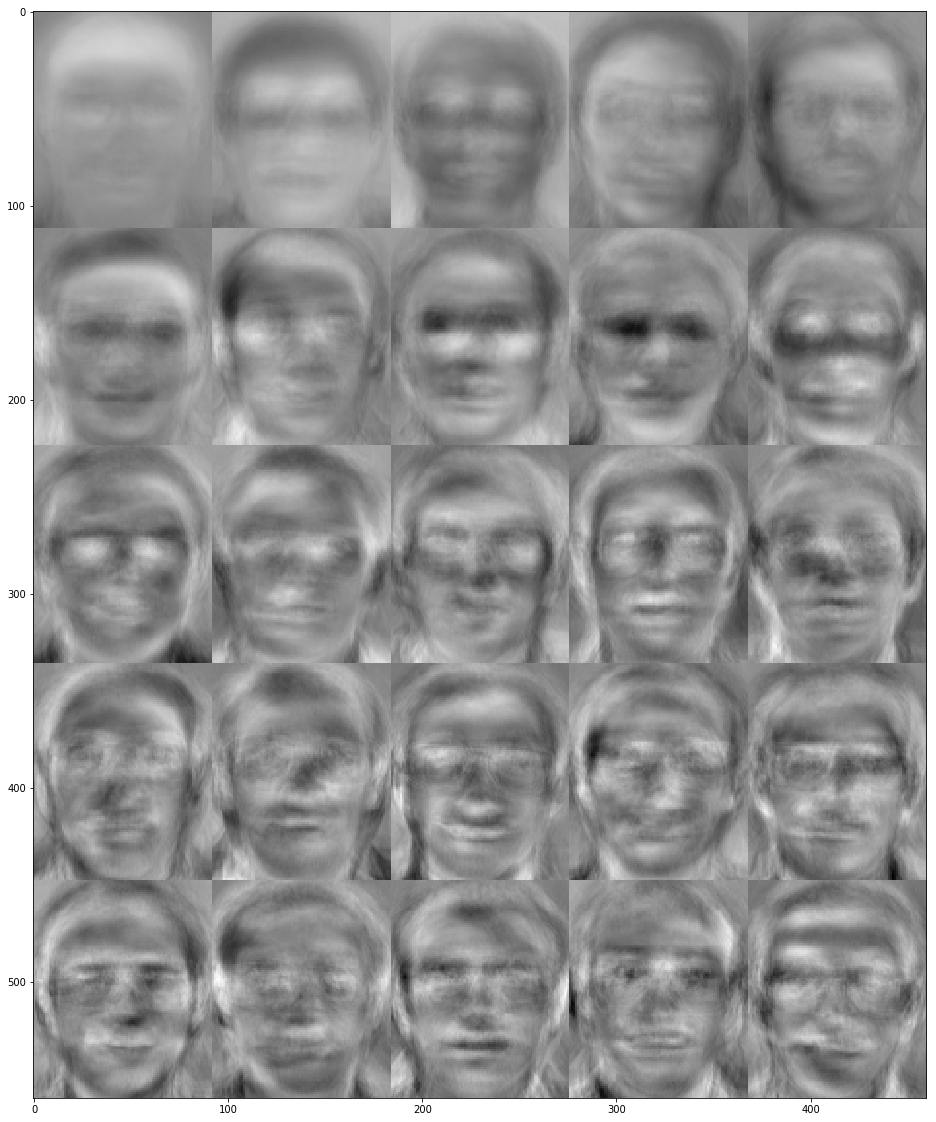

In [100]:
res, eigenface = pca(att_faces, no_dims=25)
showFaces(eigenface.T, 5)
faces = randFace(att_faces, 10)
showFaces(faces, 5)

In [101]:
def randFace(att_faces, num):
    n, d = att_faces.shape
    idx = np.random.randint(0, n, num)
    faces = att_faces[idx]
    return faces

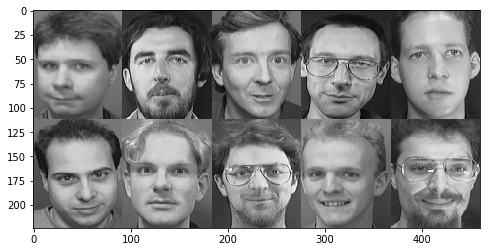

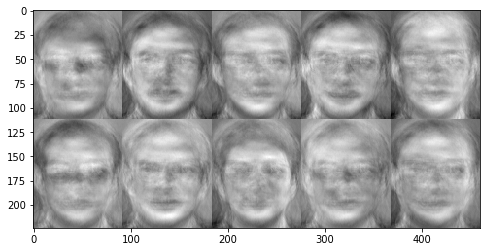

In [104]:
showFaces(faces.dot(eigenface).dot(eigenface.T), 5)